In [4]:
!pip install tensorflow_datasets

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 217.4 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 225.9 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 249.3 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 242.0 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 273.6 kB/s eta 0:00:00a 0:00:01
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21502 sha256=d3b56a6d47511199605c3fcc06eaf75096eb9e1fa8c76bb550cf65fc5bd37013
  Stored in directory: /home/laura/.cache/pip/wheels/e1/e8/83/ddea66100678d139b14bc87692ece57c6a2a937956d2532608
Successfully built promise
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they

In [5]:
import matplotlib.pyplot as plt
import os
import seaborn as sns

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

from IPython.display import clear_output

In [6]:
EPOCHS = 100
PATIENCE = 20
HEIGTH = 128
WIDTH = 128

In [7]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

2024-04-24 11:57:40.896035: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [5]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

def load_image(example):
    input_image = tf.image.resize(example['image'], (128, 128))
    input_mask = tf.image.resize(example['segmentation_mask'], (128, 128), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR,)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [6]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [7]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
train_images = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_images = test_images.batch(BATCH_SIZE)

In [9]:
train_images

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.uint8, name=None))>

In [10]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
        plt.show()

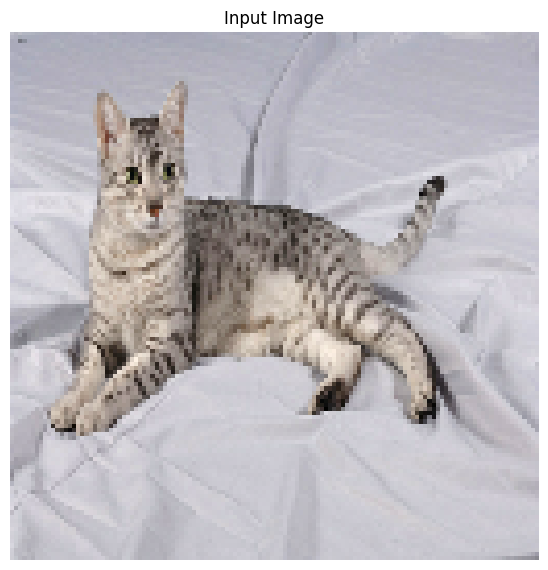

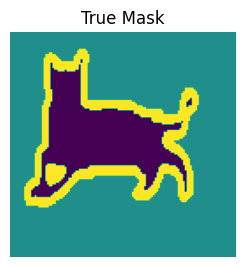

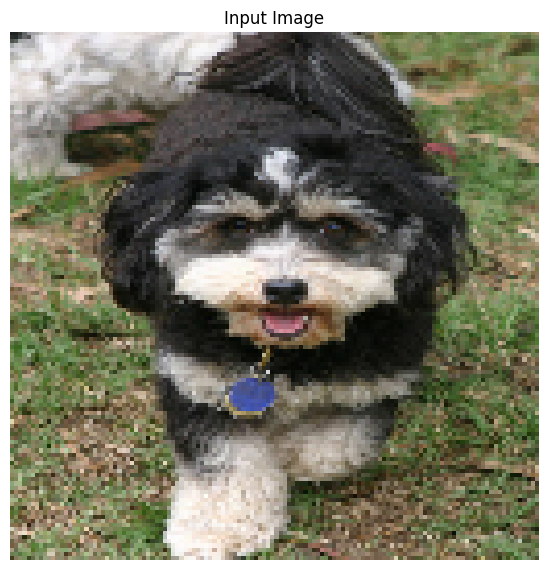

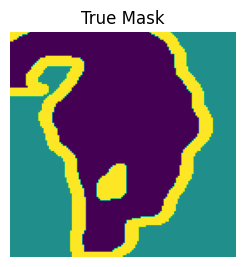

In [11]:
for images, masks in train_images.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

In [12]:
image_input = tf.keras.layers.Input((HEIGTH, WIDTH, 3), dtype=tf.float32, name="INPUT_IMAGE")

# Encoder

augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=42)(image_input)
augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=42)(image_input)

conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="SAME", activation="relu")(augment_inputs)
down_sampling_64 = tf.keras.layers.MaxPool2D(2, name="down_64")(conv_1)

conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="SAME", activation="relu")(down_sampling_64)
down_sampling_32 = tf.keras.layers.MaxPool2D(2, name="down_32")(conv_2)

conv_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="SAME", activation="relu")(down_sampling_32)
down_sampling_16 = tf.keras.layers.MaxPool2D(2, name="down_16")(conv_3)

conv_4 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="SAME", activation="relu")(down_sampling_16)
down_sampling_8 = tf.keras.layers.MaxPool2D(2, name="down_8")(conv_4)

conv_5 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="SAME", activation="relu")(down_sampling_8)
down_sampling_4 = tf.keras.layers.MaxPool2D(2, name="down_4")(conv_5)

# Decoder

upsampling_8 = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding="SAME", activation="relu")(down_sampling_4)
upsampling_8 = tf.keras.layers.Concatenate()([down_sampling_8, upsampling_8])

upsampling_16 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding="SAME", activation="relu")(upsampling_8)
upsampling_16 = tf.keras.layers.Concatenate()([down_sampling_16, upsampling_16])

upsampling_32 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding="SAME", activation="relu")(upsampling_16)
upsampling_32 = tf.keras.layers.Concatenate()([down_sampling_32, upsampling_32])

upsampling_64 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="SAME", activation="relu")(upsampling_32)
upsampling_64 = tf.keras.layers.Concatenate()([down_sampling_64, upsampling_64])

upsampling_128 = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2, padding="SAME", activation="relu")(upsampling_64)

model = tf.keras.Model(inputs=[image_input], outputs=[upsampling_128], name="model")

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 INPUT_IMAGE (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 random_flip_30 (RandomFlip)    (None, 128, 128, 3)  0           ['INPUT_IMAGE[0][0]']            
                                                                                                  
 conv2d_57 (Conv2D)             (None, 128, 128, 32  896         ['random_flip_30[0][0]']         
                                )                                                                 
                                                                                              

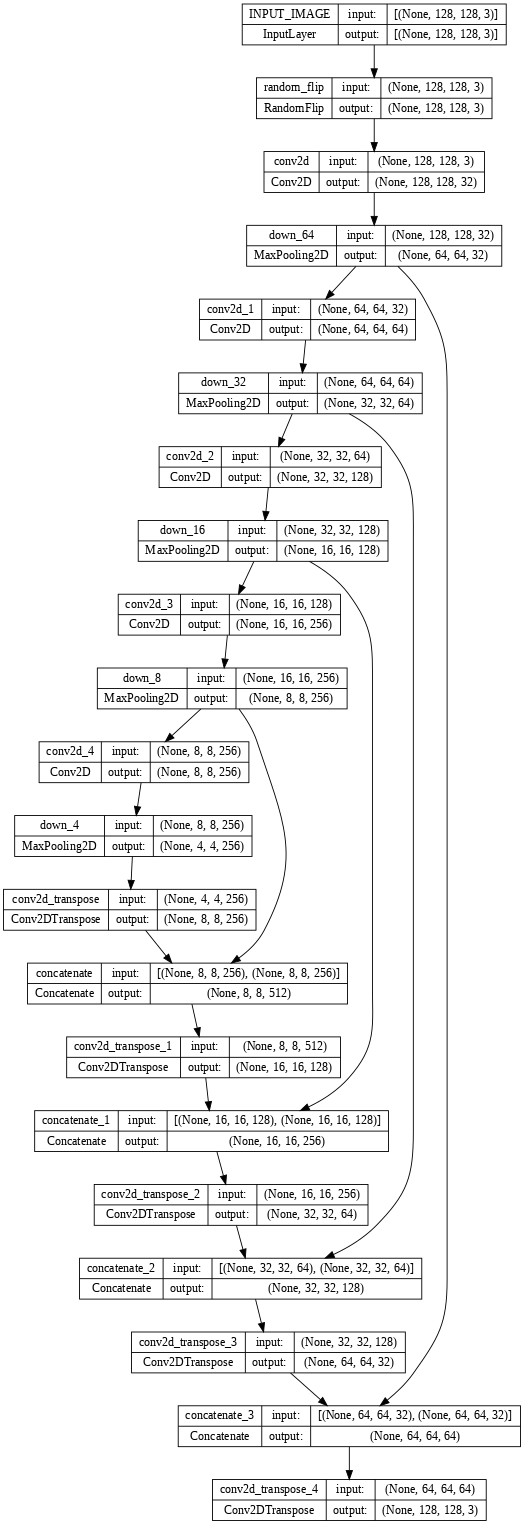

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True, dpi=64)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 219ms/step


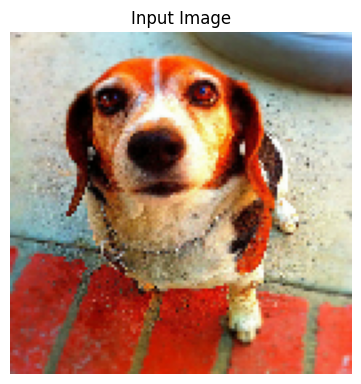

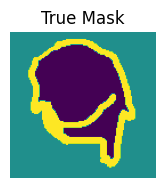

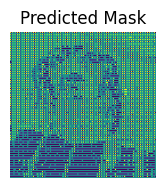

In [ ]:
show_predictions()

In [ ]:
import time
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):

        clear_output(wait=True)
        show_predictions()
        time.sleep(3)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

1/1 [==============================] - 0s 24ms/step


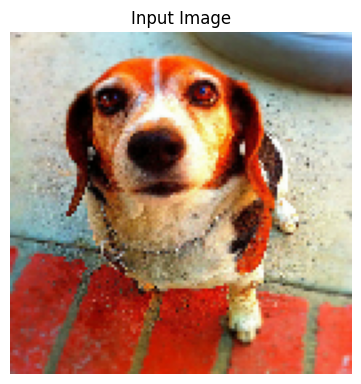

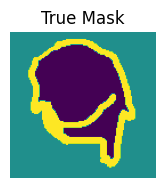

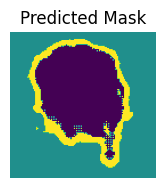


Sample Prediction after epoch 29

57/57 [==============================] - 6s 110ms/step - loss: 0.2597 - accuracy: 0.9211 - val_loss: 0.5683 - val_accuracy: 0.8486


In [ ]:
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(
    train_images,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_images,
    callbacks=[DisplayCallback(), early_stopping]
)

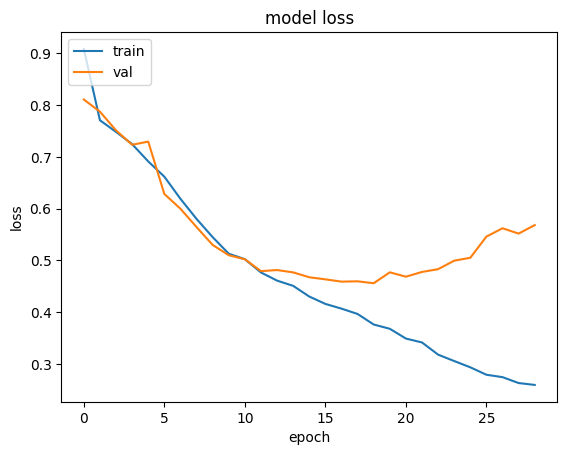

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()